# Imports

In [1]:
import numpy as np 
import pandas as pd 
import random
from huggingface_hub import login
from datasets import Dataset, DatasetDict
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Read Grammer DataFrame

In [2]:
new_column_names = ["input", "target"]

n_rows =  100
df1 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00000-of-00010',sep = '\t',nrows = n_rows)
df1.columns = new_column_names
df2 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00001-of-00010',sep = '\t',nrows = n_rows)
df2.columns = new_column_names
df3 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00002-of-00010',sep = '\t',nrows = n_rows)
df3.columns = new_column_names
df4 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00003-of-00010',sep = '\t',nrows = n_rows)
df4.columns = new_column_names
df5 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00004-of-00010',sep = '\t',nrows = n_rows)
df5.columns = new_column_names
df6 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00005-of-00010',sep = '\t',nrows = n_rows)
df6.columns = new_column_names
df7 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00006-of-00010',sep = '\t',nrows = n_rows)
df7.columns = new_column_names
df8 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00007-of-00010',sep = '\t',nrows = n_rows)
df8.columns = new_column_names
df9 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00008-of-00010',sep = '\t',nrows = n_rows)
df9.columns = new_column_names
df10 = pd.read_csv('/kaggle/input/c4200m/C4_200M.tsv-00009-of-00010',sep = '\t',nrows = n_rows)
df10.columns = new_column_names
df = pd.concat((df1,df2,df3,df4,df5,df6,df7,df8,df9,df10),axis = 0)
df.head()

,input,target
0,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
1,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...
2,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
3,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...
4,"Fairy Or Not, I'm the Godmother: no just look,...","Fairy Or Not, I'm the Godmother: Not just a lo..."


# Preprocessing

In [3]:
df.duplicated().sum()

0

In [4]:
df.isna().sum()

input     0
target    0
dtype: int64

df8move instances with sth like numerical bullet points in the target like :

In [5]:
subset_df = df[(df['target'].str[0].str.isdigit() & (~ df['input'].str[0].str.isdigit()))]
subset_df

,input,target
0,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
88,There are 5 secrets from behind the front desk!,5 secrets from behind the front desk!
7,There are 3. Fully drain and fully recharge yo...,3. Fully drain and fully recharge your replace...
36,e1 The Real Nolla Noise : The Real Conert of G...,1. The Real Noble Noise : The Real Concert of ...
81,Monster 1997- monster now has two discs of fro...,1997: Ducati M750 Monster now has two front di...
96,Lacy cardis is the parach for feminine elegance.,13. Lacy cardis are the paragon of feminine el...
79,Fursmall things is i can do for make a big som...,4. What small things can I do right now to mak...


In [6]:
# Function to find improper characters
def find_improper_chars(text):
    import re
    # Define the allowed character pattern
    allowed_pattern = r'^[a-zA-Z0-9\s.,!?\'"()-]+$'
    # Find characters that do not match the allowed pattern
    return set(re.findall(r'[^a-zA-Z0-9\s.,!?\'"();:\\/^*-]', text))

# Find improper characters in the 'definition' column
improper_chars_set = set()
for definition in df['input']:
    improper_chars_set.update(find_improper_chars(definition))

for definition in df['input']:
    improper_chars_set.update(find_improper_chars(definition))

print(improper_chars_set)


{'•', '©', 'é', '\u0c49', '¨', '{', 'с', '\u200b', 'č', '…', 'á', ']', '–', 'о', 'ç', '&', 'ō', '%', '|', 'ć', '®', '‘', 'ÿ', '_', 'ı', '～', 'š', 'ͼ', '@', 'а', '£', 'α', '`', '#', 'ς', '\u200f', '$', '¡', '″', '”', '😀', 'е', '~', '>', '™', 'ğ', '°', '[', '—', '<', '’', 'Т', '“', '×', '+', '🥚', '紫', 'ś', '='}


In [7]:
df[df['input'].str.find('😀') != -1]

,input,target
77,I love smoothies😀That loaks absolutel ydelicious.,I love smoothies😀That looks absolutely delicious.


In [8]:
# Remove rows with improper characters
mask_input = df['input'].str.match(r'^[a-zA-Z0-9\s.\$,!?\'"():;&%*\\/^-]+$')
mask_target = df['input'].str.match(r'^[a-zA-Z0-9\s.\$,!?\'"():;&%*\\/^-]+$')
cleaned_df = df[mask_input & mask_target]
cleaned_df.shape

(786, 2)

In [9]:
filtered_df = cleaned_df[~(cleaned_df['target'].str[0].str.isdigit() & (~ cleaned_df['input'].str[0].str.isdigit()))]
filtered_df.shape

(779, 2)

The VADER lexicon (Valence Aware Dictionary and sEntiment Reasoner) is a specialized sentiment analysis tool designed for analyzing textual data. It is particularly effective for social media texts, short comments, and any other text that may contain slang, emojis, or informal language. Here are some key features of the VADER lexicon:

Outputs: When using VADER for sentiment analysis, it provides several output metrics, including:

- Positive: Proportion of positive sentiment.
- Negative: Proportion of negative sentiment.
- Neutral: Proportion of neutral sentiment.
- Compound: A single score summarizing the overall sentiment.

In [10]:

# Download the VADER lexicon (only need to do this once)
nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [11]:
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def get_sentiment_scores(sentence):
    return sia.polarity_scores(sentence)

# Calculate sentiment scores for input and target
df['input_sentiment'] = df['input'].apply(get_sentiment_scores)
df['target_sentiment'] = df['target'].apply(get_sentiment_scores)

# Expand the sentiment scores into separate columns
sentiment_columns = df['input_sentiment'].apply(pd.Series)
df = pd.concat([df, sentiment_columns], axis=1)
df.rename(columns={'neg': 'input_neg', 'neu': 'input_neu', 'pos': 'input_pos', 'compound': 'input_compound'}, inplace=True)

sentiment_columns = df['target_sentiment'].apply(pd.Series)
df = pd.concat([df, sentiment_columns], axis=1)
df.rename(columns={'neg': 'target_neg', 'neu': 'target_neu', 'pos': 'target_pos', 'compound': 'target_compound'}, inplace=True)

# Display the updated dataframe
df[['input', 'target', 'input_compound', 'target_compound']].head()


,input,target,input_compound,target_compound
0,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ...",-0.6249,-0.6249
1,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...,0.7906,0.9432
2,Much many brands and sellers still in the market.,Many brands and sellers still in the market.,0.0000,0.0000
3,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...,0.0000,0.0000
4,"Fairy Or Not, I'm the Godmother: no just look,...","Fairy Or Not, I'm the Godmother: Not just a lo...",-0.1531,0.0000


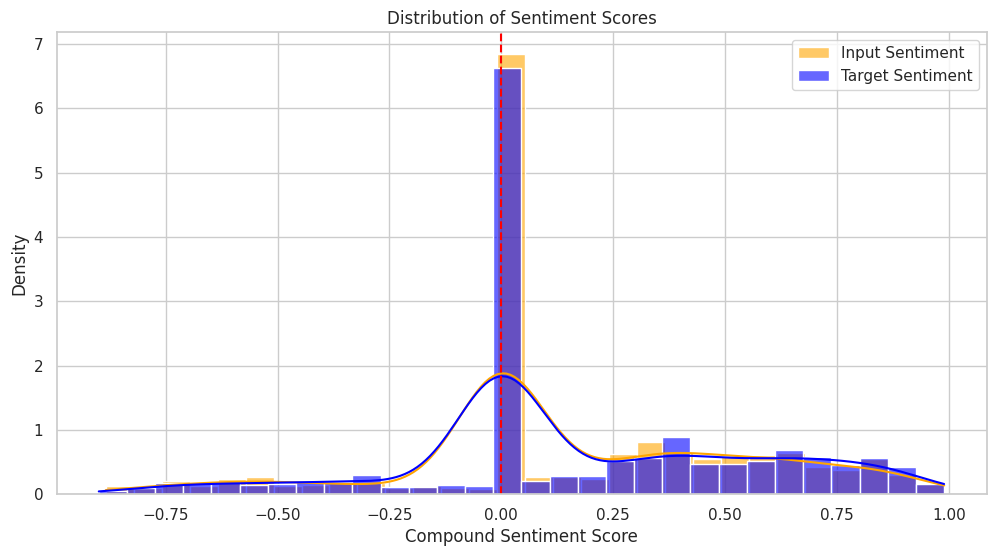

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set(style='whitegrid')

# Plot compound sentiment scores for input and target
plt.figure(figsize=(12, 6))

# Plot for input_compound with a specific color
sns.histplot(df['input_compound'], bins=30, color='orange', kde=True, label='Input Sentiment', stat='density', alpha=0.6)

# Plot for target_compound with a different color
sns.histplot(df['target_compound'], bins=30, color='blue', kde=True, label='Target Sentiment', stat='density', alpha=0.6)

plt.legend()
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Density')
plt.axvline(0, color='red', linestyle='--', label='Neutral')
plt.show()



In sentiment analysis, the compound score is a single numeric value that summarizes the overall sentiment of a text. This score ranges from -1 to +1:

- -1 indicates extremely negative sentiment.
- 0 indicates a neutral sentiment.
- +1 indicates extremely positive sentiment.

In [13]:
# Function to calculate sentence length and word count
def sentence_stats(sentence):
    words = sentence.split()
    return len(sentence), len(words)

# Calculate sentence lengths and word counts for input and target
df[['input_length', 'input_word_count']] = df['input'].apply(sentence_stats).apply(pd.Series)
df[['target_length', 'target_word_count']] = df['target'].apply(sentence_stats).apply(pd.Series)

# Display descriptive statistics
df[['input_length', 'input_word_count', 'target_length', 'target_word_count']].describe().T



,count,mean,std,min,25%,50%,75%,max
input_length,1000.0,134.589,99.521709,21.0,63.0,108.0,175.00,859.0
input_word_count,1000.0,22.520,16.196850,3.0,11.0,18.0,29.25,135.0
target_length,1000.0,135.053,99.773027,22.0,63.0,107.0,175.25,722.0
target_word_count,1000.0,22.496,16.249740,5.0,11.0,18.0,30.00,111.0


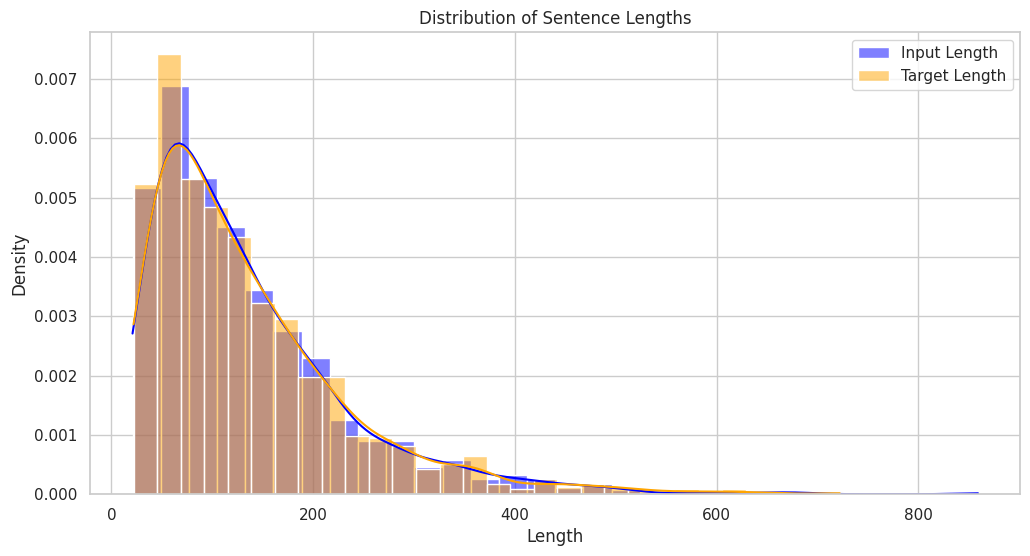

In [14]:
# Set the aesthetics for the plots
sns.set(style='whitegrid')

# Plot sentence length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['input_length'], bins=30, color='blue', kde=True, label='Input Length', stat='density')
sns.histplot(df['target_length'], bins=30, color='orange', kde=True, label='Target Length', stat='density')
plt.legend()
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Density')
plt.show()


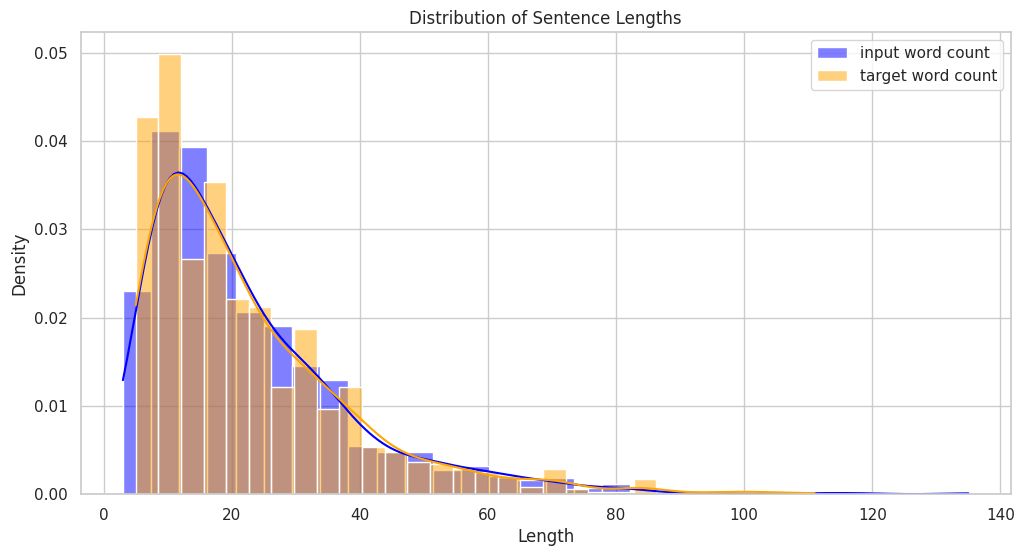

In [15]:
sns.set(style='whitegrid')

# Plot sentence length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['input_word_count'], bins=30, color='blue', kde=True, label='input word count', stat='density')
sns.histplot(df['target_word_count'], bins=30, color='orange', kde=True, label='target word count', stat='density')
plt.legend()
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Density')
plt.show()

# Transform Dataframe into the Desired Shape

In [16]:
# List of variations of dialog-friendly questions

dialog_friendly_questions = [
    "Could you help me fix this sentence?",
    "Can you correct the grammar in this sentence?",
    "Would you mind checking this sentence for errors?",
    "Can you point out the mistakes in this sentence?",
    "Could you suggest a better way to phrase this?",
    "Is there a grammatical error in this sentence?",
    "Can you help me rephrase this?",
    "How would you correct this sentence?",
    "What do you think about this sentence?",
    "Can you review this sentence for me?"
]


kindly_beginnings = [
    "Sure, here's a corrected version.",
    "Absolutely, here’s the revised sentence.",
    "Of course, here’s how it should read.",
    "Certainly! Here’s the improved version.",
    "Yes, here’s a better phrasing.",
    "Of course! Here’s the corrected sentence.",
    "Absolutely! Here’s the right version.",
    "Sure thing! Here’s the fixed sentence.",
    "Certainly! Here’s a grammatically accurate version.",
    "Yes, here's how you can improve it."
]
len(dialog_friendly_questions), len(kindly_beginnings)


(10, 10)

In [17]:
def transform(row):
    incorrect_sentence = row['input']
    question_random_index = random.randint(0, len(dialog_friendly_questions)-1)
    question = f"{dialog_friendly_questions[question_random_index]} The sentence is {row['input']}"
    
    answer_random_index = random.randint(0, len(kindly_beginnings)-1)
    answer = f"{kindly_beginnings[answer_random_index]} {row['target']}"
    prompt = '<s>[INST] {question} [/INST] {answer} </s>'.format(question=question, answer=answer)

    return prompt



In [18]:
transformed_df = pd.DataFrame(filtered_df.apply(transform, axis=1))

In [19]:
transformed_df.columns = ['text']

transformed_df.head()

,text
1,<s>[INST] Is there a grammatical error in this...
2,<s>[INST] Could you help me fix this sentence?...
3,<s>[INST] How would you correct this sentence?...
4,<s>[INST] How would you correct this sentence?...
5,<s>[INST] Can you review this sentence for me?...


# Save to CSV

In [20]:
transformed_df.to_csv('grammer_correction_dataset.csv', index=False)

# Another Transform [Question and Answer columns]

In [21]:
def transform_q(q):
    question_random_index = random.randint(0, len(dialog_friendly_questions)-1)
    question = f"{dialog_friendly_questions[question_random_index]} The sentence is {q}"
    
    
    
    return question

def transform_a(a):
    answer_random_index = random.randint(0, len(kindly_beginnings)-1)
    answer = f"{kindly_beginnings[answer_random_index]} {a}"
    
    return answer


In [22]:
qna_df = pd.DataFrame()

In [23]:
qna_df['question'] = filtered_df['input'].map(transform_q)
qna_df['answer'] = filtered_df['target'].map(transform_a)

In [24]:
qna_df.head()

,question,answer
1,Would you mind checking this sentence for erro...,Certainly! Here’s the improved version. Capita...
2,Would you mind checking this sentence for erro...,"Yes, here's how you can improve it. Many brand..."
3,Could you suggest a better way to phrase this?...,Certainly! Here’s the improved version. This i...
4,Can you point out the mistakes in this sentenc...,"Yes, here's how you can improve it. Fairy Or N..."
5,Would you mind checking this sentence for erro...,Absolutely! Here’s the right version. Watch as...


In [25]:
split = 200
qna_df = pd.concat([qna_df[:split], qna_df[-split:]], axis=0)

In [26]:
qna_df.head()

,question,answer
1,Would you mind checking this sentence for erro...,Certainly! Here’s the improved version. Capita...
2,Would you mind checking this sentence for erro...,"Yes, here's how you can improve it. Many brand..."
3,Could you suggest a better way to phrase this?...,Certainly! Here’s the improved version. This i...
4,Can you point out the mistakes in this sentenc...,"Yes, here's how you can improve it. Fairy Or N..."
5,Would you mind checking this sentence for erro...,Absolutely! Here’s the right version. Watch as...


In [27]:
qna_df.shape

(400, 2)

# Save to CSV

In [28]:
qna_df.to_csv('grammer_correction_dataset_qna.csv', index=False)